# 基于AReaL端到端强化学习训练一个通过反思解决数学问题智能体

本文件利用AReaL中提供的组件快速搭建一个可以端到端强化学习训练的智能体。

这个智能体通过反思（reflection）解决GSM8K中的数学问题。

下面的代码块主要包括以下步骤：
1. 实验准备：从yaml加载实验配置，配置环境变量，启动SGLang服务器，加载GSM8k数据集；
4. 定义简单的单轮生成工作流；
5. 将单轮工作流改成多轮，每条数据可以轮数不一样；
6. 每次生成**多条**多轮数据（i.e., GRPO)；
7. 测试多轮工作流；
8. 将工作流接入端到端GRPO强化学习训练。

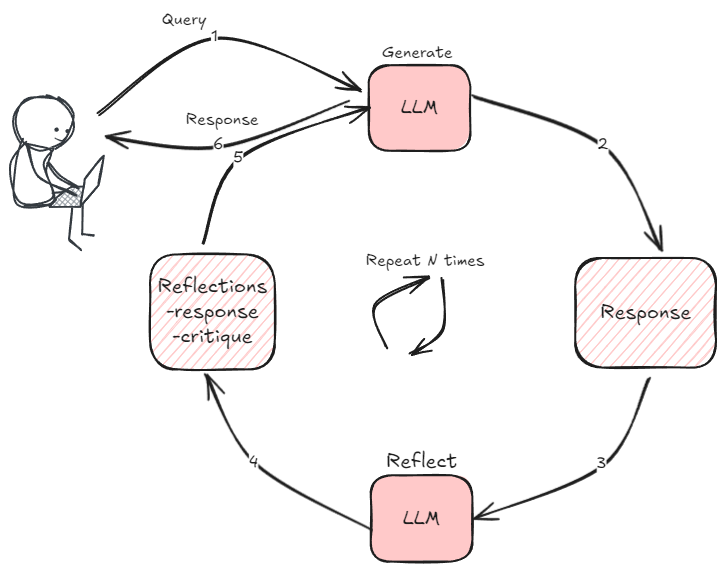

In [ ]:
# 配置实验环境
!bash examples/env/setup-pip-deps.sh

## 实验准备

### 加载实验配置

以下代码通过`load_expr_config`加载预先定义的GSM8K GRPO yaml实验配置模板。

这份模板配置了优化器、模型、学习率等等参数，方便我们直接使用。


In [ ]:
from dataclasses import asdict, dataclass

from areal.api.cli_args import GRPOConfig, load_expr_config

args = ["--config", "examples/math/gsm8k_grpo.yaml"]
config, _ = load_expr_config(args, GRPOConfig)
config: GRPOConfig

### 配置环境变量

我们预先分配SGLang服务器和PyTorch分布式启动的IP地址和端口，并设置相应的环境变量。

这些环境变量会在引擎初始化时被读取。

***在非notebook环境下，这些环境变量会被launcher设置，用户无需自行设置。***

In [ ]:
from areal.utils.network import find_free_ports

SGLANG_PORT, MASTER_PORT = 11451, 14514

SGLANG_HOST = "127.0.0.1"

# Environment variables used by inference/train engines
import os

os.environ["AREAL_LLM_SERVER_ADDRS"] = f"{SGLANG_HOST}:{SGLANG_PORT}"
os.environ["MASTER_ADDR"] = "127.0.0.1"
os.environ["MASTER_PORT"] = str(MASTER_PORT)
os.environ["RANK"] = str(0)
os.environ["WORLD_SIZE"] = str(1)
os.environ["TOKENIZERS_PARALLELISM"] = "true"
os.environ["LOCAL_RANK"] = str(0)

### 启动SGLang服务器

AReaL默认采用训推分离式架构，推理和训练异步执行，能够打满GPU资源、快速完成端到端训练。

在这个样例中，强化学习的算法编排（GRPO）运行在GPU 0上。

GPU 1运行一个推理服务器，强化学习的算法编排可以向GPU 1上的推理服务发送生成请求。

下面的代码块在GPU 1上启动对应的推理服务。

In [ ]:
import subprocess
import sys

# 启动sglang server
from areal.api.cli_args import SGLangConfig
from areal.utils.network import find_free_ports

config.sglang.log_level = "info"
config.sglang.decode_log_interval = 10
sglang_cmd = SGLangConfig.build_cmd(
    config.sglang,
    tp_size=1,
    base_gpu_id=1,
    host=SGLANG_HOST,
    port=SGLANG_PORT,
)
sglang_process = subprocess.Popen(
    sglang_cmd,
    shell=True,
    stdout=sys.stdout,
    stderr=sys.stderr,
)

### 加载GSM8k数据集

利用HuggingFace `datasets`包加载GSM8k数据集，并查看数据集格式。

In [ ]:
# load gsm8k dataset
from datasets import load_dataset

dataset = load_dataset(path="openai/gsm8k", name="main", split="train")
print(f">>> dataset column names: {dataset.column_names}")
print(f">>> example data: {dataset[0]}")

### 导入必要的python包和模块

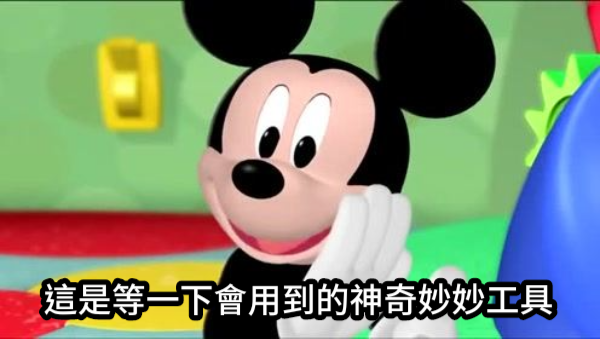

In [ ]:
import asyncio
import functools
import os
import time
import uuid

import colorama
import torch
from transformers import AutoTokenizer, PreTrainedTokenizerFast

from areal.api.cli_args import GenerationHyperparameters
from areal.api.engine_api import InferenceEngine
from areal.api.io_struct import (
    AllocationMode,
    FinetuneSpec,
    ModelRequest,
    WeightUpdateMeta,
)
from areal.api.workflow_api import RolloutWorkflow
from areal.engine.ppo.actor import FSDPPPOActor
from areal.engine.sglang_remote import RemoteSGLangEngine
from areal.utils.data import concat_padded_tensors, tensor_container_to
from areal.utils.device import log_gpu_stats

tokenizer = AutoTokenizer.from_pretrained(config.tokenizer_path)
if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id

进行适当的数据处理，将数据格式转换成可以进行OpenAI对话的格式。

In [ ]:
def process(sample):
    messages = [{"role": "user", "content": sample["question"]}]
    return {"messages": messages}


dataset = dataset.map(process).remove_columns(["question"])
print(f">>> example data: {dataset[0]}")

In [ ]:
from torchdata.stateful_dataloader import StatefulDataLoader

dataloader = StatefulDataLoader(
    dataset,
    batch_size=config.train_dataset.batch_size,
    shuffle=True,
    collate_fn=lambda x: x,
    drop_last=True,
)
from itertools import cycle

data_generator = cycle(dataloader)

ft_spec = FinetuneSpec(
    total_train_epochs=config.total_train_epochs,
    dataset_size=len(dataloader) * config.train_dataset.batch_size,
    train_batch_size=config.train_dataset.batch_size,
)

x = next(data_generator)
print(f">>> The type of a batch is: {type(x)}\n")
print(f">>> Each piece of data has keys: {x[0].keys()}\n")
print(f">>> Example rollout input: {x[0]['messages']}\n")

## 定义简单的单轮工作流

单轮对话工作流利用推理引擎生成一条问题的答案，并用奖励函数计算生成奖励

### 定义奖励函数

In [ ]:
from concurrent.futures import ProcessPoolExecutor

rw_executor = ProcessPoolExecutor(max_workers=4)

from realhf.impl.dataset.math_parser import extract_answer, math_equal

REWARD_TIMEOUT_SECONDS = 15


def reward_fn(generated, answer):
    try:
        x = extract_answer(generated, "math", use_last_number=True)
        y = extract_answer(answer, "math", use_last_number=True)

        if x is None or x.strip() in ["None", "none", ""]:
            return 0.0
        elif y is None or y.strip() in ["None", "none", ""]:
            return 0.0
        return float(math_equal(x, y, timeout=False))
    except:
        return 0.0


# TODO: examine reward function
reward_fn(
    "\boxed{72}",
    "Natalia sold 48/2 = <<48/2=24>>24 clips in May.\nNatalia sold 48+24 = <<48+24=72>>72 clips altogether in April and May.\n#### 72",
)

### 定义工作流

单轮工作流也被称为“具有可验证奖励的强化学习”（Reinforcement Learning from Verifiable Rewards, RLVR)。

RLVR的工作流非常简单：

1. 从数据集中加载一条数据；
2. 调用推理引擎进行生成；
3. 调用奖励函数计算reward。

In [ ]:
# TODO: implement


class RLVRWorkflow:
    def __init__(self, gconfig, verbose):
        self.gconfig = gconfig
        self.verbose = verbose

    async def gen(self, engine, input_ids, rid, answer):
        req = ModelRequest(rid=rid, input_ids=input_ids, gconfig=self.gconfig)
        resp = await engine.agenerate(req)
        loop = asyncio.get_event_loop()
        completions_str = tokenizer.decode(resp.output_tokens)
        reward = await loop.run_in_executor(
            rw_executor, functools.partial(reward_fn, completions_str, answer)
        )
        if self.verbose:
            print(f">>> prompt str: {tokenizer.decode(resp.input_tokens)}")
            print(f">>> generated: {tokenizer.decode(resp.output_tokens)}")
            print(f">>> answer: {answer}")
            print(f">>> reward: {reward}")
        return resp, reward

    async def arun_episode(self, engine, data):
        assert self.gconfig.n_samples == 1
        prompt_ids = tokenizer.apply_chat_template(
            data["messages"],
            apply_chat_template=True,
            tokenize=True,
        )
        resp, reward = await self.gen(
            engine, prompt_ids, uuid.uuid4().hex, data["answer"]
        )
        input_ids = resp.input_tokens + resp.output_tokens
        logprobs = [0.0] * resp.input_len + resp.output_logprobs
        loss_mask = [0] * resp.input_len + [1] * resp.output_len

        res = dict(
            input_ids=torch.tensor(input_ids),
            logprobs=torch.tensor(logprobs),
            loss_mask=torch.tensor(loss_mask),
            reward=torch.tensor(reward),
            attention_mask=torch.ones(len(input_ids)),
        )
        # [bs, seqlen]
        res = {k: v.unsqueeze(0) for k, v in res.items()}
        return res

### 测试单轮工作流

1. 创建推理引擎；
2. 创建工作流；
3. 将工作流传入推理引擎进行批量生成。

In [ ]:
# initialize inference engine
rollout = RemoteSGLangEngine(config.rollout)
rollout.initialize()
try:
    # TODO: create workflow
    workflow = RLVRWorkflow(
        gconfig=GenerationHyperparameters(max_new_tokens=512), verbose=True
    )
    sample_data = next(data_generator)[:2]
    res = rollout.rollout_batch(sample_data, workflow=workflow)
    print(res)
finally:
    rollout.destroy()

## 将单轮工作流拓展成多轮带反思的工作流

核心逻辑：执行一个while循环，在LLM答案不正确的时候，加入一个prompt让它反思，并生成下一次答案。

为了防止LLM进行无限反思，需要在多轮反思后的奖励上加入折扣因子（discount factor）减小奖励的值。

### 创建反思提示

由于某些tokenizer在encode-decode过程中会有token ID不一致的情况，我们需要提前创建好反思提示的token ID加入模型的反思过程中。

In [ ]:
messages = [{"role": "assistant", "content": "some random message."}]
prefix = tokenizer.apply_chat_template(messages, tokenize=False)
s1 = tokenizer.apply_chat_template(messages, tokenize=True)
messages += [
    {
        "role": "user",
        "content": "\nYour answer is either wrong or not parsable to the reward function. Please try to answer it again.",
    }
]
s2 = tokenizer.apply_chat_template(messages, tokenize=True, add_generation_prompt=True)
s = tokenizer.apply_chat_template(messages, tokenize=False)
reflection_tokens = s2[len(s1) :]
print(f">>> prefix string:\n{prefix}\n")
print(f">>> prefix token id:\n{s1}\n")
print(f">>> whole string:\n{s}\n")
print(f">>> whole sentence token id:\n{s2}\n")

In [ ]:
class ReflectionWorkflow:
    def __init__(self, gconfig, max_turns, turn_discount, verbose=False):
        self.gconfig = gconfig
        self.max_turns = max_turns
        self.turn_discount = turn_discount
        self.verbose = verbose

    async def arun_episode(self, engine: InferenceEngine, data):
        messages = data["messages"]
        # Convert the prompt into input_ids
        input_ids = tokenizer.apply_chat_template(
            messages,
            tokenize=True,
            add_generation_prompt=True,
        )
        assert self.gconfig.n_samples == 1
        t = reward = 0
        discount = 1
        rid = uuid.uuid4().hex
        seq = []
        logprobs = []
        loss_mask = []
        # TODO: implement reflection
        while t < self.max_turns and reward == 0:
            resp, reward = await RLVRWorkflow(self.gconfig, self.verbose).gen(
                engine, input_ids, rid, data["answer"]
            )
            input_len = resp.input_len - len(seq)
            seq += resp.input_tokens[-input_len:] + resp.output_tokens
            logprobs += [0.0] * input_len + resp.output_logprobs
            loss_mask += [0] * input_len + [1] * resp.output_len
            t += 1
            if reward == 0:
                input_ids += resp.output_tokens
                if input_ids[-1] != tokenizer.eos_token_id:
                    input_ids += [tokenizer.eos_token_id]
                input_ids += reflection_tokens
                discount *= self.turn_discount

        res = dict(
            input_ids=torch.tensor(seq),
            logprobs=torch.tensor(logprobs),
            loss_mask=torch.tensor(loss_mask),
            rewards=torch.tensor(float(reward * discount)),
            attention_mask=torch.ones(len(seq), dtype=torch.bool),
        )
        res = {k: v.unsqueeze(0) for k, v in res.items()}
        return res

### 测试带反思的工作流

In [ ]:
# initialize inference engine
rollout = RemoteSGLangEngine(config.rollout)
rollout.initialize()
try:
    # create workflow
    workflow = ReflectionWorkflow(
        gconfig=GenerationHyperparameters(n_samples=1, max_new_tokens=512),
        max_turns=5,
        turn_discount=0.9,
        verbose=True,
    )
    sample_data = next(data_generator)[:2]
    res = rollout.rollout_batch(sample_data, workflow=workflow)
    print(res)
finally:
    rollout.destroy()

## 让reflection工作流对每个问题生成多个答案

类似GRPO的算法需要针对每个问题生成一组多个答案。

我们可以通过一个asyncio的并行技巧同时向推理服务提交请求，高效地生成多个答案。

In [ ]:
class GroupedReflectionWorkflow:
    def __init__(self, gconfig, max_turns, turn_discount, verbose=False):
        self.gconfig = gconfig
        self.max_turns = max_turns
        self.turn_discount = turn_discount
        self.verbose = verbose

    async def arun_episode(self, engine, data):
        workflows = [
            ReflectionWorkflow(
                self.gconfig.new(n_samples=1),
                self.max_turns,
                self.turn_discount,
                self.verbose,
            )
            for _ in range(self.gconfig.n_samples)
        ]
        tasks = [workflow.arun_episode(engine, data) for workflow in workflows]
        results = await asyncio.gather(*tasks)
        return concat_padded_tensors(results)

In [ ]:
# initialize inference engine
rollout = RemoteSGLangEngine(config.rollout)
rollout.initialize()
try:
    # create workflow
    workflow = GroupedReflectionWorkflow(
        gconfig=GenerationHyperparameters(n_samples=3, max_new_tokens=512),
        max_turns=5,
        turn_discount=0.9,
        verbose=False,
    )
    sample_data = next(data_generator)[:2]
    res = rollout.rollout_batch(sample_data, workflow=workflow)
    print(res)
finally:
    rollout.destroy()

## 将工作流接入强化学习训练流程

上面我们已经测试好了负责的推理工作流，接下来我们需要将这个工作流接入到训练过程中。

这需要我们额外创建一个专门针对PPO的训练引擎，并在training loop中循环调用推理和训练。

### 同步训练

In [ ]:
workflow = GroupedReflectionWorkflow(
    gconfig=GenerationHyperparameters(n_samples=3, max_new_tokens=512),
    max_turns=5,
    turn_discount=0.9,
    verbose=False,
)
actor = FSDPPPOActor(config=config.actor)
actor.initialize(None, ft_spec)

rollout = RemoteSGLangEngine(config.rollout)
rollout.initialize()

weight_update_meta = WeightUpdateMeta.from_fsdp_xccl(
    AllocationMode.from_str("sglang.d1p1t1+d1p1t1")
)

warmup_steps = 1
times = []
for global_step in range(5):
    if global_step >= warmup_steps:
        tik = time.perf_counter()
    batch = rollout.rollout_batch(next(data_generator), workflow=workflow)
    batch = tensor_container_to(batch, actor.device)

    logp = actor.compute_logp(batch)
    batch["prox_logp"] = logp

    actor.compute_advantages(batch)

    stats = actor.ppo_update(batch)
    actor.step_lr_scheduler()

    rollout.pause()
    actor.update_weights(weight_update_meta)
    rollout.resume()

    actor.set_version(global_step + 1)
    rollout.set_version(global_step + 1)
    if global_step >= warmup_steps:
        times.append(time.perf_counter() - tik)
print(times)

### 异步训练

In [ ]:
workflow = GroupedReflectionWorkflow(
    gconfig=GenerationHyperparameters(n_samples=3, max_new_tokens=512),
    max_turns=5,
    turn_discount=0.9,
    verbose=False,
)
actor = FSDPPPOActor(config=config.actor)
actor.initialize(None, ft_spec)

rollout = RemoteSGLangEngine(config.rollout)
rollout.initialize()

weight_update_meta = WeightUpdateMeta.from_fsdp_xccl(
    AllocationMode.from_str("sglang.d1p1t1+d1p1t1")
)
weight_update_meta.nccl_group_name = "group2"

warmup_steps = 1
times = []
for global_step in range(5):
    if global_step >= warmup_steps:
        tik = time.perf_counter()
    batch = rollout.prepare_batch(dataloader, workflow=workflow)
    batch = tensor_container_to(batch, actor.device)

    logp = actor.compute_logp(batch)
    batch["prox_logp"] = logp

    actor.compute_advantages(batch)

    stats = actor.ppo_update(batch)
    actor.step_lr_scheduler()

    rollout.pause()
    actor.update_weights(weight_update_meta)
    rollout.resume()

    actor.set_version(global_step + 1)
    rollout.set_version(global_step + 1)
    if global_step >= warmup_steps:
        times.append(time.perf_counter() - tik)
print(times)

In [ ]:
import signal as signal_module

import psutil


def terminate_process_and_children(pid: int, signal=None):
    if signal is None:
        signal = signal_module.SIGKILL
    if isinstance(signal, str):
        signal = getattr(signal_module, signal)
    try:
        parent = psutil.Process(pid)
        children = parent.children(recursive=True)
        for child in children:
            terminate_process_and_children(child.pid)
        parent.send_signal(signal)
    except psutil.NoSuchProcess:
        pass


terminate_process_and_children(sglang_process.pid)

In [ ]:
rollout.destroy()

In [ ]:
actor.destroy()

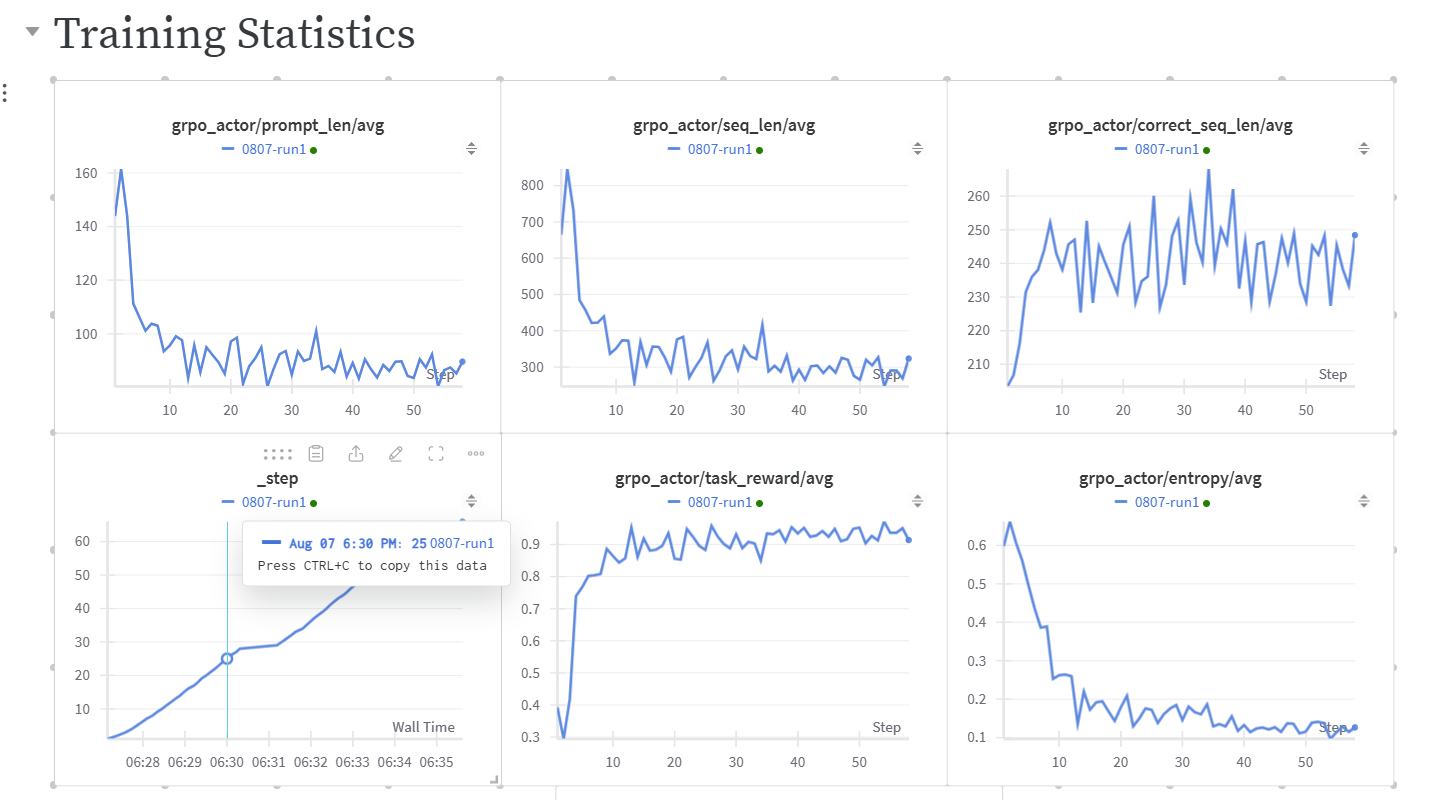